In [1]:
#Manpulate
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from category_encoders import BinaryEncoder # Nominal Encoding 
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling

# Modeling
## 1) Pipeline
from sklearn.pipeline import Pipeline, make_pipeline # to make pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector # apply pipeline to each column

## 2) Regression Models
from sklearn.linear_model import LinearRegression # if data is small and small_no_features
from sklearn.linear_model import SGDRegressor # if data is large: (can have penalty=constrains)
from sklearn.preprocessing import PolynomialFeatures # for polynomial regresion (then apply scaling after it)
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV # Regularization 

## 3) Model Selection (Underfitting vs Overfitting) [bias variance tradeoff => perfect model complexity]
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # (Train - Valid - Test) + hyperparameters tunning 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV # if data / features is large
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Evaluate Model: r2=> accuracy, L2-norm: if no outliers, L1-norm: if outliers
from scipy import stats # Confidence Interval of Accuracy / Loss / Utility
import joblib # save model

## Read & Understand

In [2]:
df = pd.read_csv('loan_data.csv')
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
df.select_dtypes(include=['number']).describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [5]:
older_than_100 = df[df['person_age'] > 100].index
df.drop(older_than_100, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [6]:
df[df['person_emp_exp'] > 80]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status


In [7]:
cat_cols = df.select_dtypes(include="O").columns

for col in cat_cols:
    print(f"number of uniques of \'{col}\' is: {df[col].nunique()}")
    print(f"uniques of \'{col}\' is:\n{df[col].unique()}")
    print()
    print('*' * 50)
    print()

number of uniques of 'person_gender' is: 2
uniques of 'person_gender' is:
['female' 'male']

**************************************************

number of uniques of 'person_education' is: 5
uniques of 'person_education' is:
['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']

**************************************************

number of uniques of 'person_home_ownership' is: 4
uniques of 'person_home_ownership' is:
['RENT' 'OWN' 'MORTGAGE' 'OTHER']

**************************************************

number of uniques of 'loan_intent' is: 6
uniques of 'loan_intent' is:
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

**************************************************

number of uniques of 'previous_loan_defaults_on_file' is: 2
uniques of 'previous_loan_defaults_on_file' is:
['No' 'Yes']

**************************************************



In [8]:
for col in cat_cols:
    print(f"count of each unique in column \'{col}\' is:\n{df[col].value_counts()}")
    print()
    print('*' * 50)
    print()

count of each unique in column 'person_gender' is:
person_gender
male      24836
female    20157
Name: count, dtype: int64

**************************************************

count of each unique in column 'person_education' is:
person_education
Bachelor       13396
Associate      12026
High School    11970
Master          6980
Doctorate        621
Name: count, dtype: int64

**************************************************

count of each unique in column 'person_home_ownership' is:
person_home_ownership
RENT        23440
MORTGAGE    18485
OWN          2951
OTHER         117
Name: count, dtype: int64

**************************************************

count of each unique in column 'loan_intent' is:
loan_intent
EDUCATION            9151
MEDICAL              8548
VENTURE              7815
PERSONAL             7551
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

**************************************************

count of each unique in column 'previous_

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

## Feature Extraction

In [11]:
def credit_score_rate(credit_score):

    if credit_score >= 750:
        return ('Excellent')
    elif credit_score >= 650:
        return ('Good')
    elif credit_score >= 550:
        return ('Average')
    else:
        return ('poor')
    

df["credit_score_rate"] = df["credit_score"].apply(credit_score_rate)
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,credit_score_rate
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1,Average
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0,poor
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1,Average
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1,Good
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44988,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1,Average
44989,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1,Average
44990,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1,Good
44991,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1,Average


In [12]:
def Age_group(person_age):

    if 20 <= person_age <= 30:
        return ('Young')
    elif 31 <= person_age <= 50:
        return ('Middle')
    else:
        return ('Senior')
    

df["Age_group"] = df["person_age"].apply(Age_group)
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,credit_score_rate,Age_group
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1,Average,Young
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0,poor,Young
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1,Average,Young
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1,Good,Young
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1,Average,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44988,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1,Average,Young
44989,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1,Average,Middle
44990,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1,Good,Middle
44991,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1,Average,Young


In [13]:
def income_rate(person_income):

    if person_income <= 50000:
        return ('Low')
    elif 50000 < person_income <= 150000:
        return ('Average')
    elif 150000 < person_income <= 500000:
        return ('High')
    else:
        return ('Elite')
    
    
df["income_rate"] = df["person_income"].apply(income_rate)
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,credit_score_rate,Age_group,income_rate
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1,Average,Young,Average
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0,poor,Young,Low
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1,Average,Young,Low
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1,Good,Young,Average
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1,Average,Young,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44988,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1,Average,Young,Low
44989,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1,Average,Middle,Average
44990,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1,Good,Middle,Average
44991,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1,Average,Young,Low


## EDA

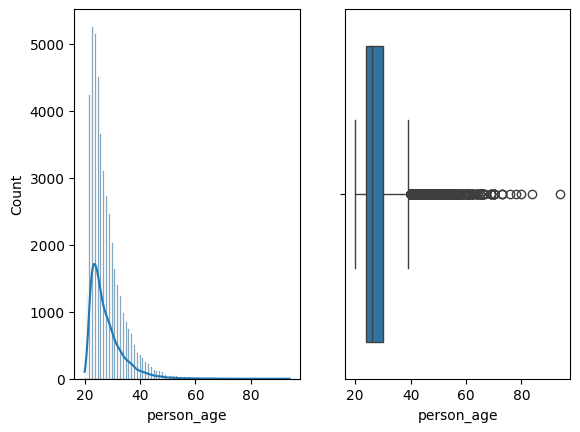

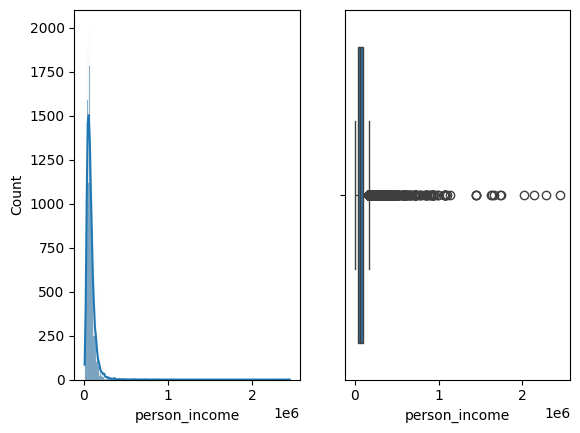

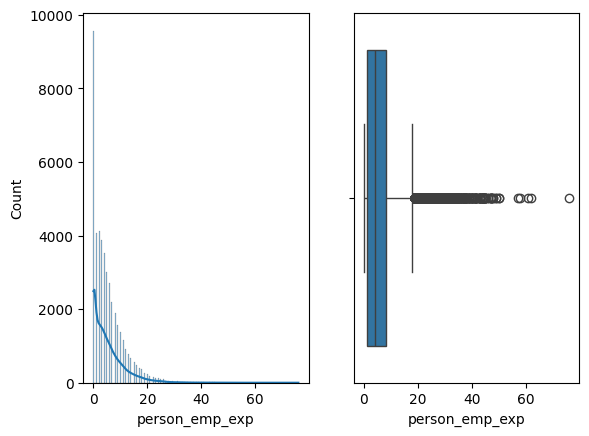

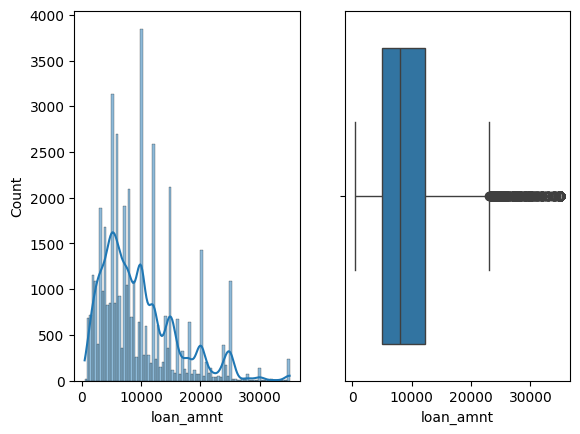

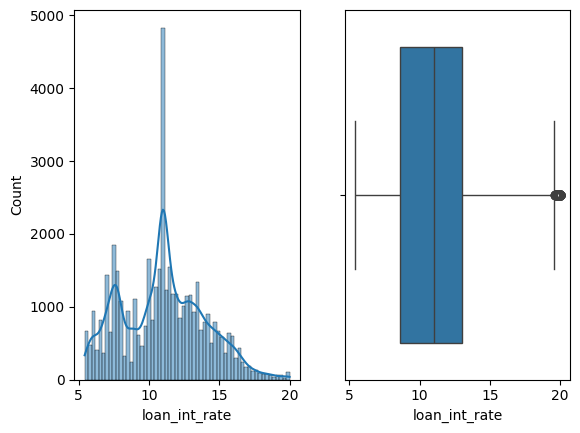

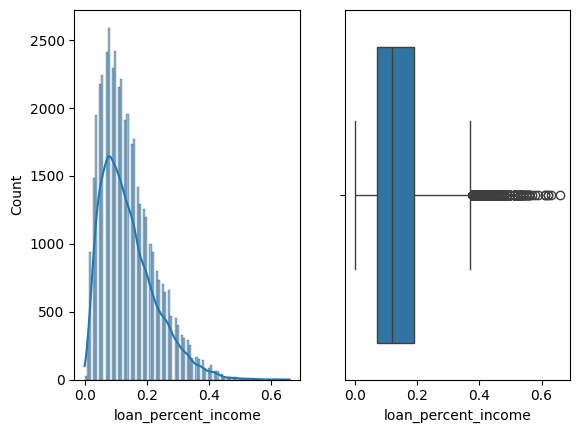

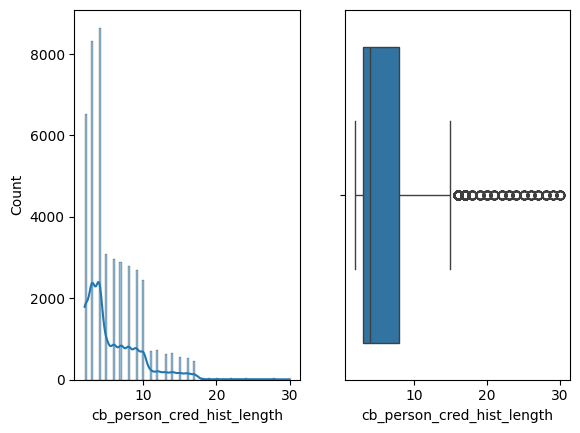

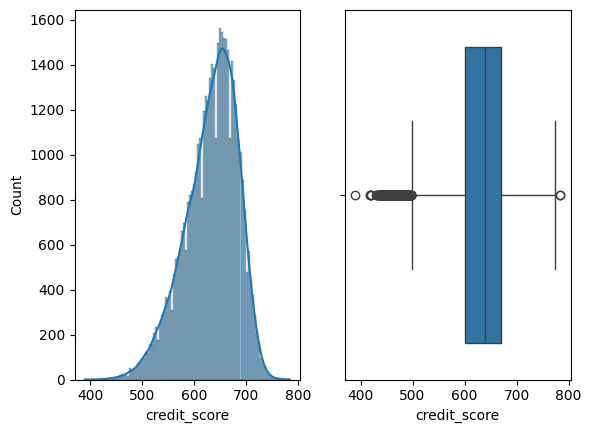

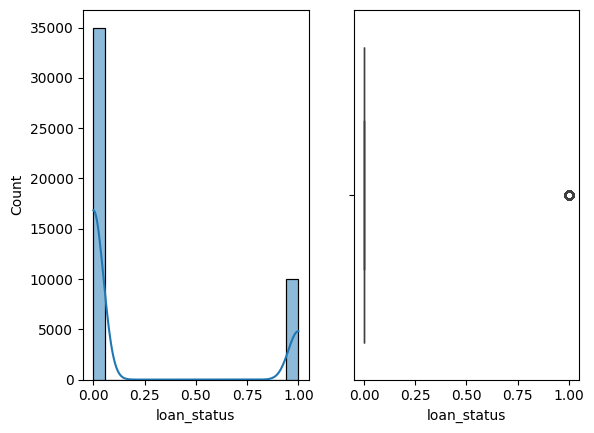

In [14]:
num_cols = df.select_dtypes(include="number").columns

for col in num_cols:
    fig, axes= plt.subplots(nrows=1, ncols=2)
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])
    plt.show()



## Age : right skewed
## Income : right skewed
## All right skewed except credit score (no oultiers)

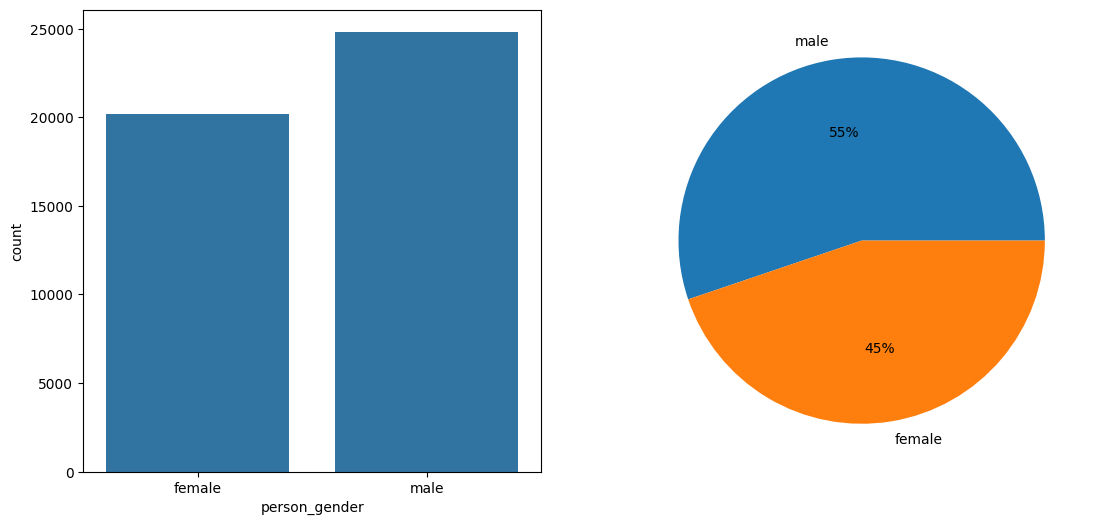

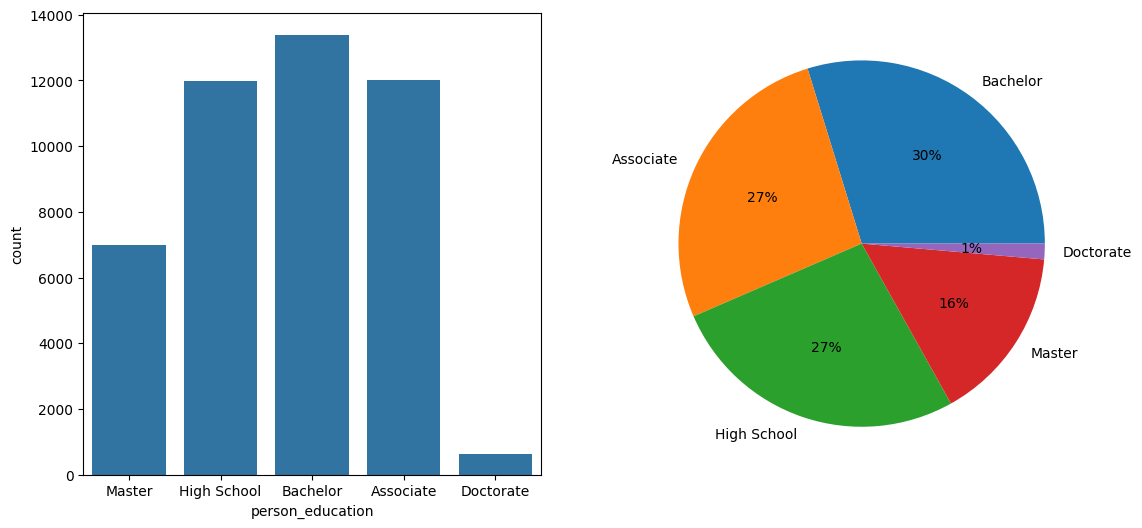

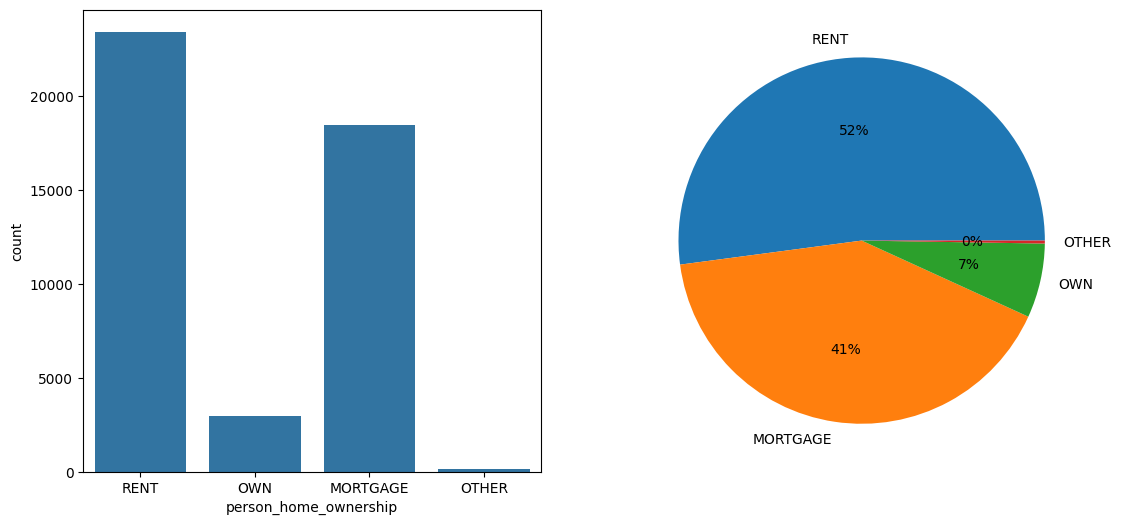

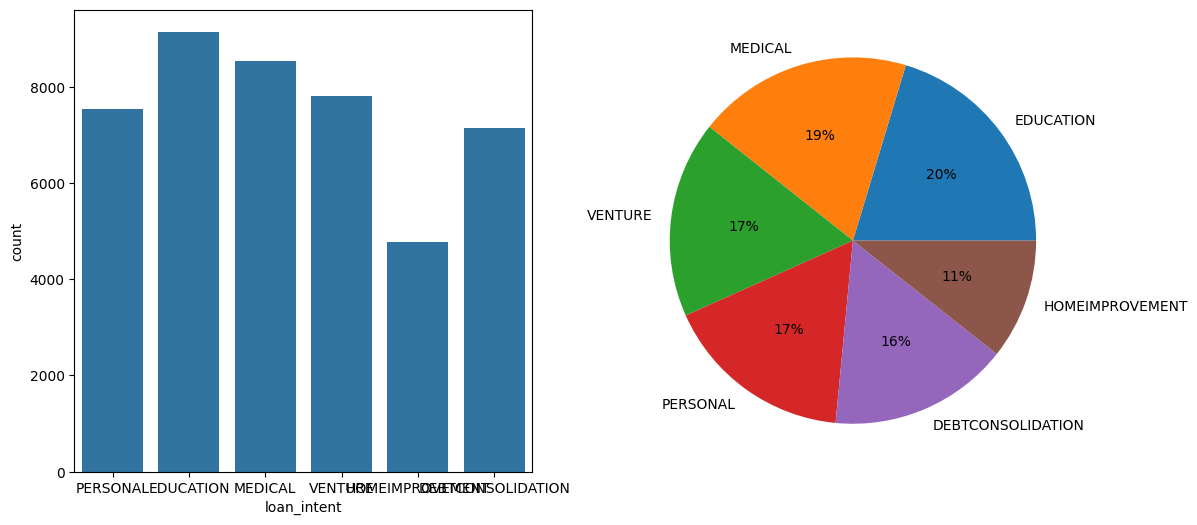

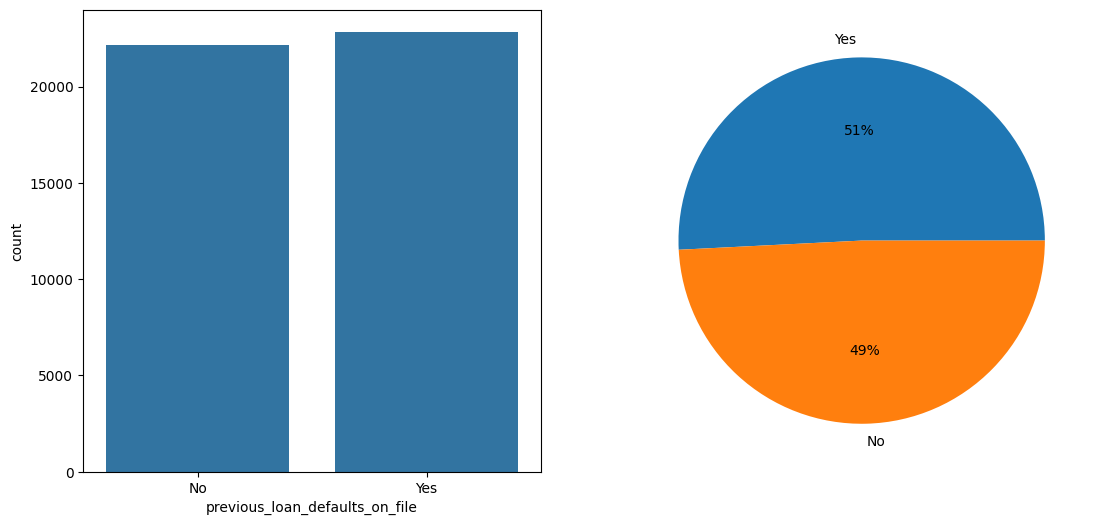

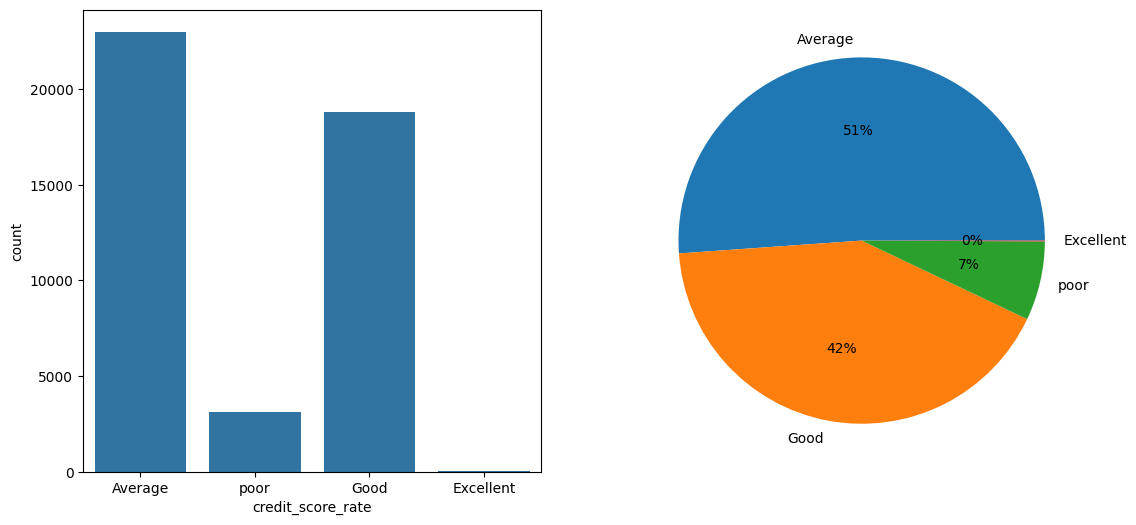

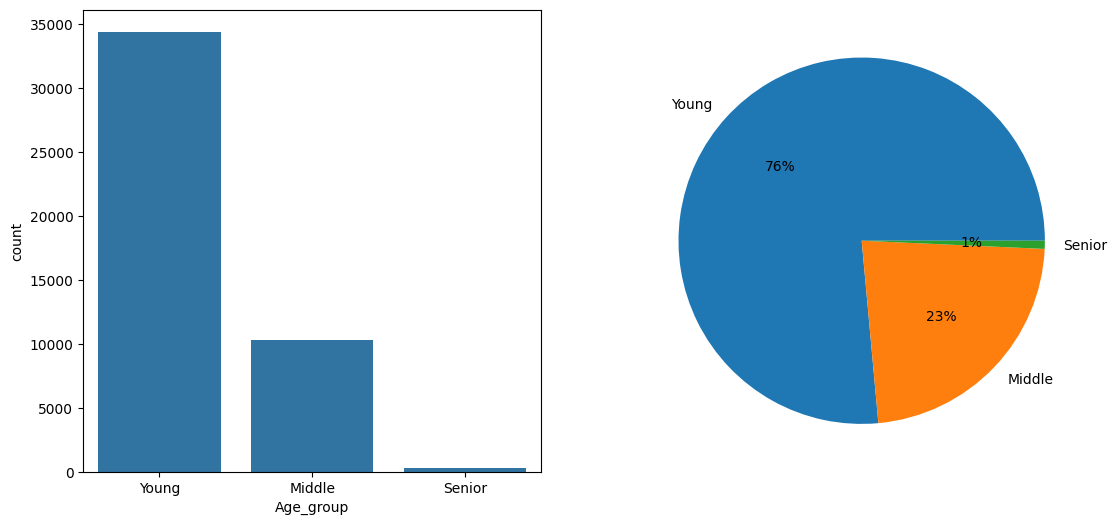

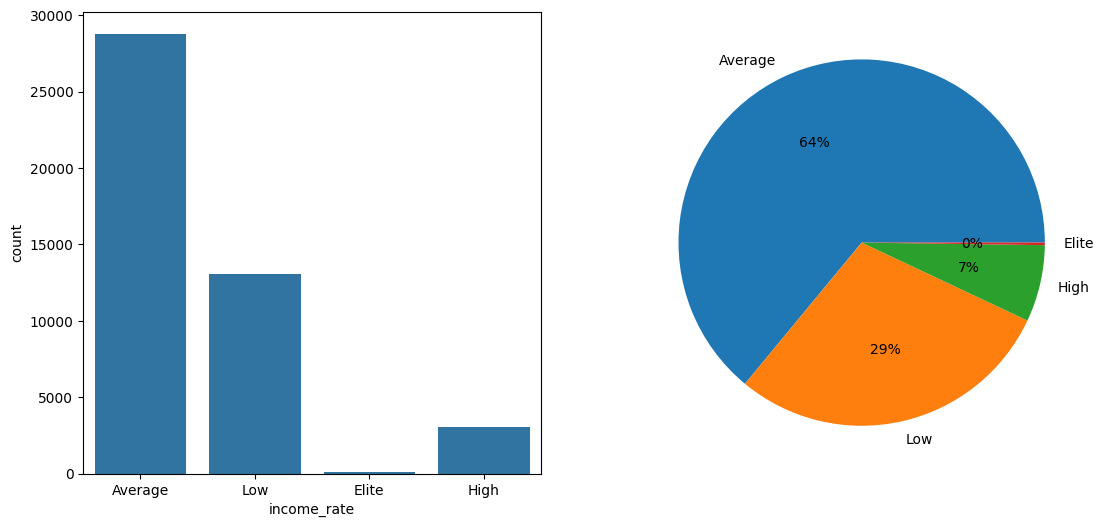

In [15]:
cat_cols = df.select_dtypes("O").columns
for col in cat_cols:
    fig, axes = plt.subplots(1,2, figsize=(13,6))
    sns.countplot(df, x=col, ax=axes[0])
    plt.xticks(rotation=45)
    counts = df[col].value_counts()
    plt.pie(counts, labels=counts.index, autopct="%.0f%%")
    plt.show()


<Axes: >

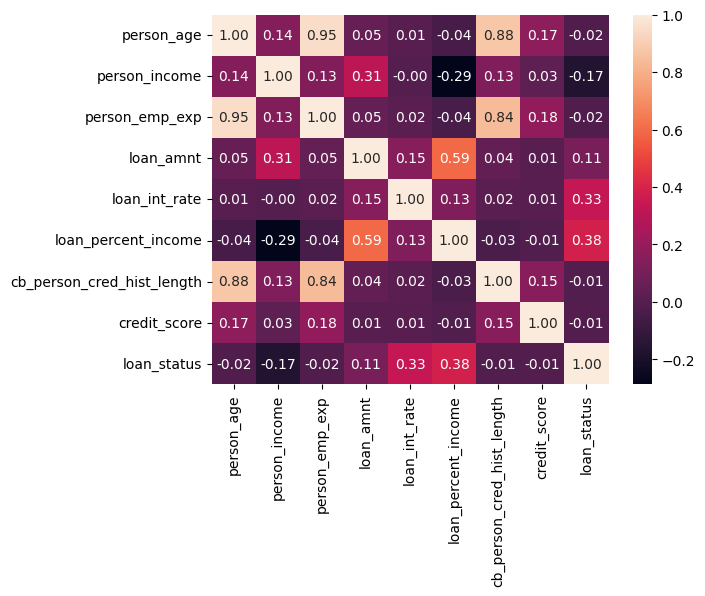

In [16]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt='.2f')

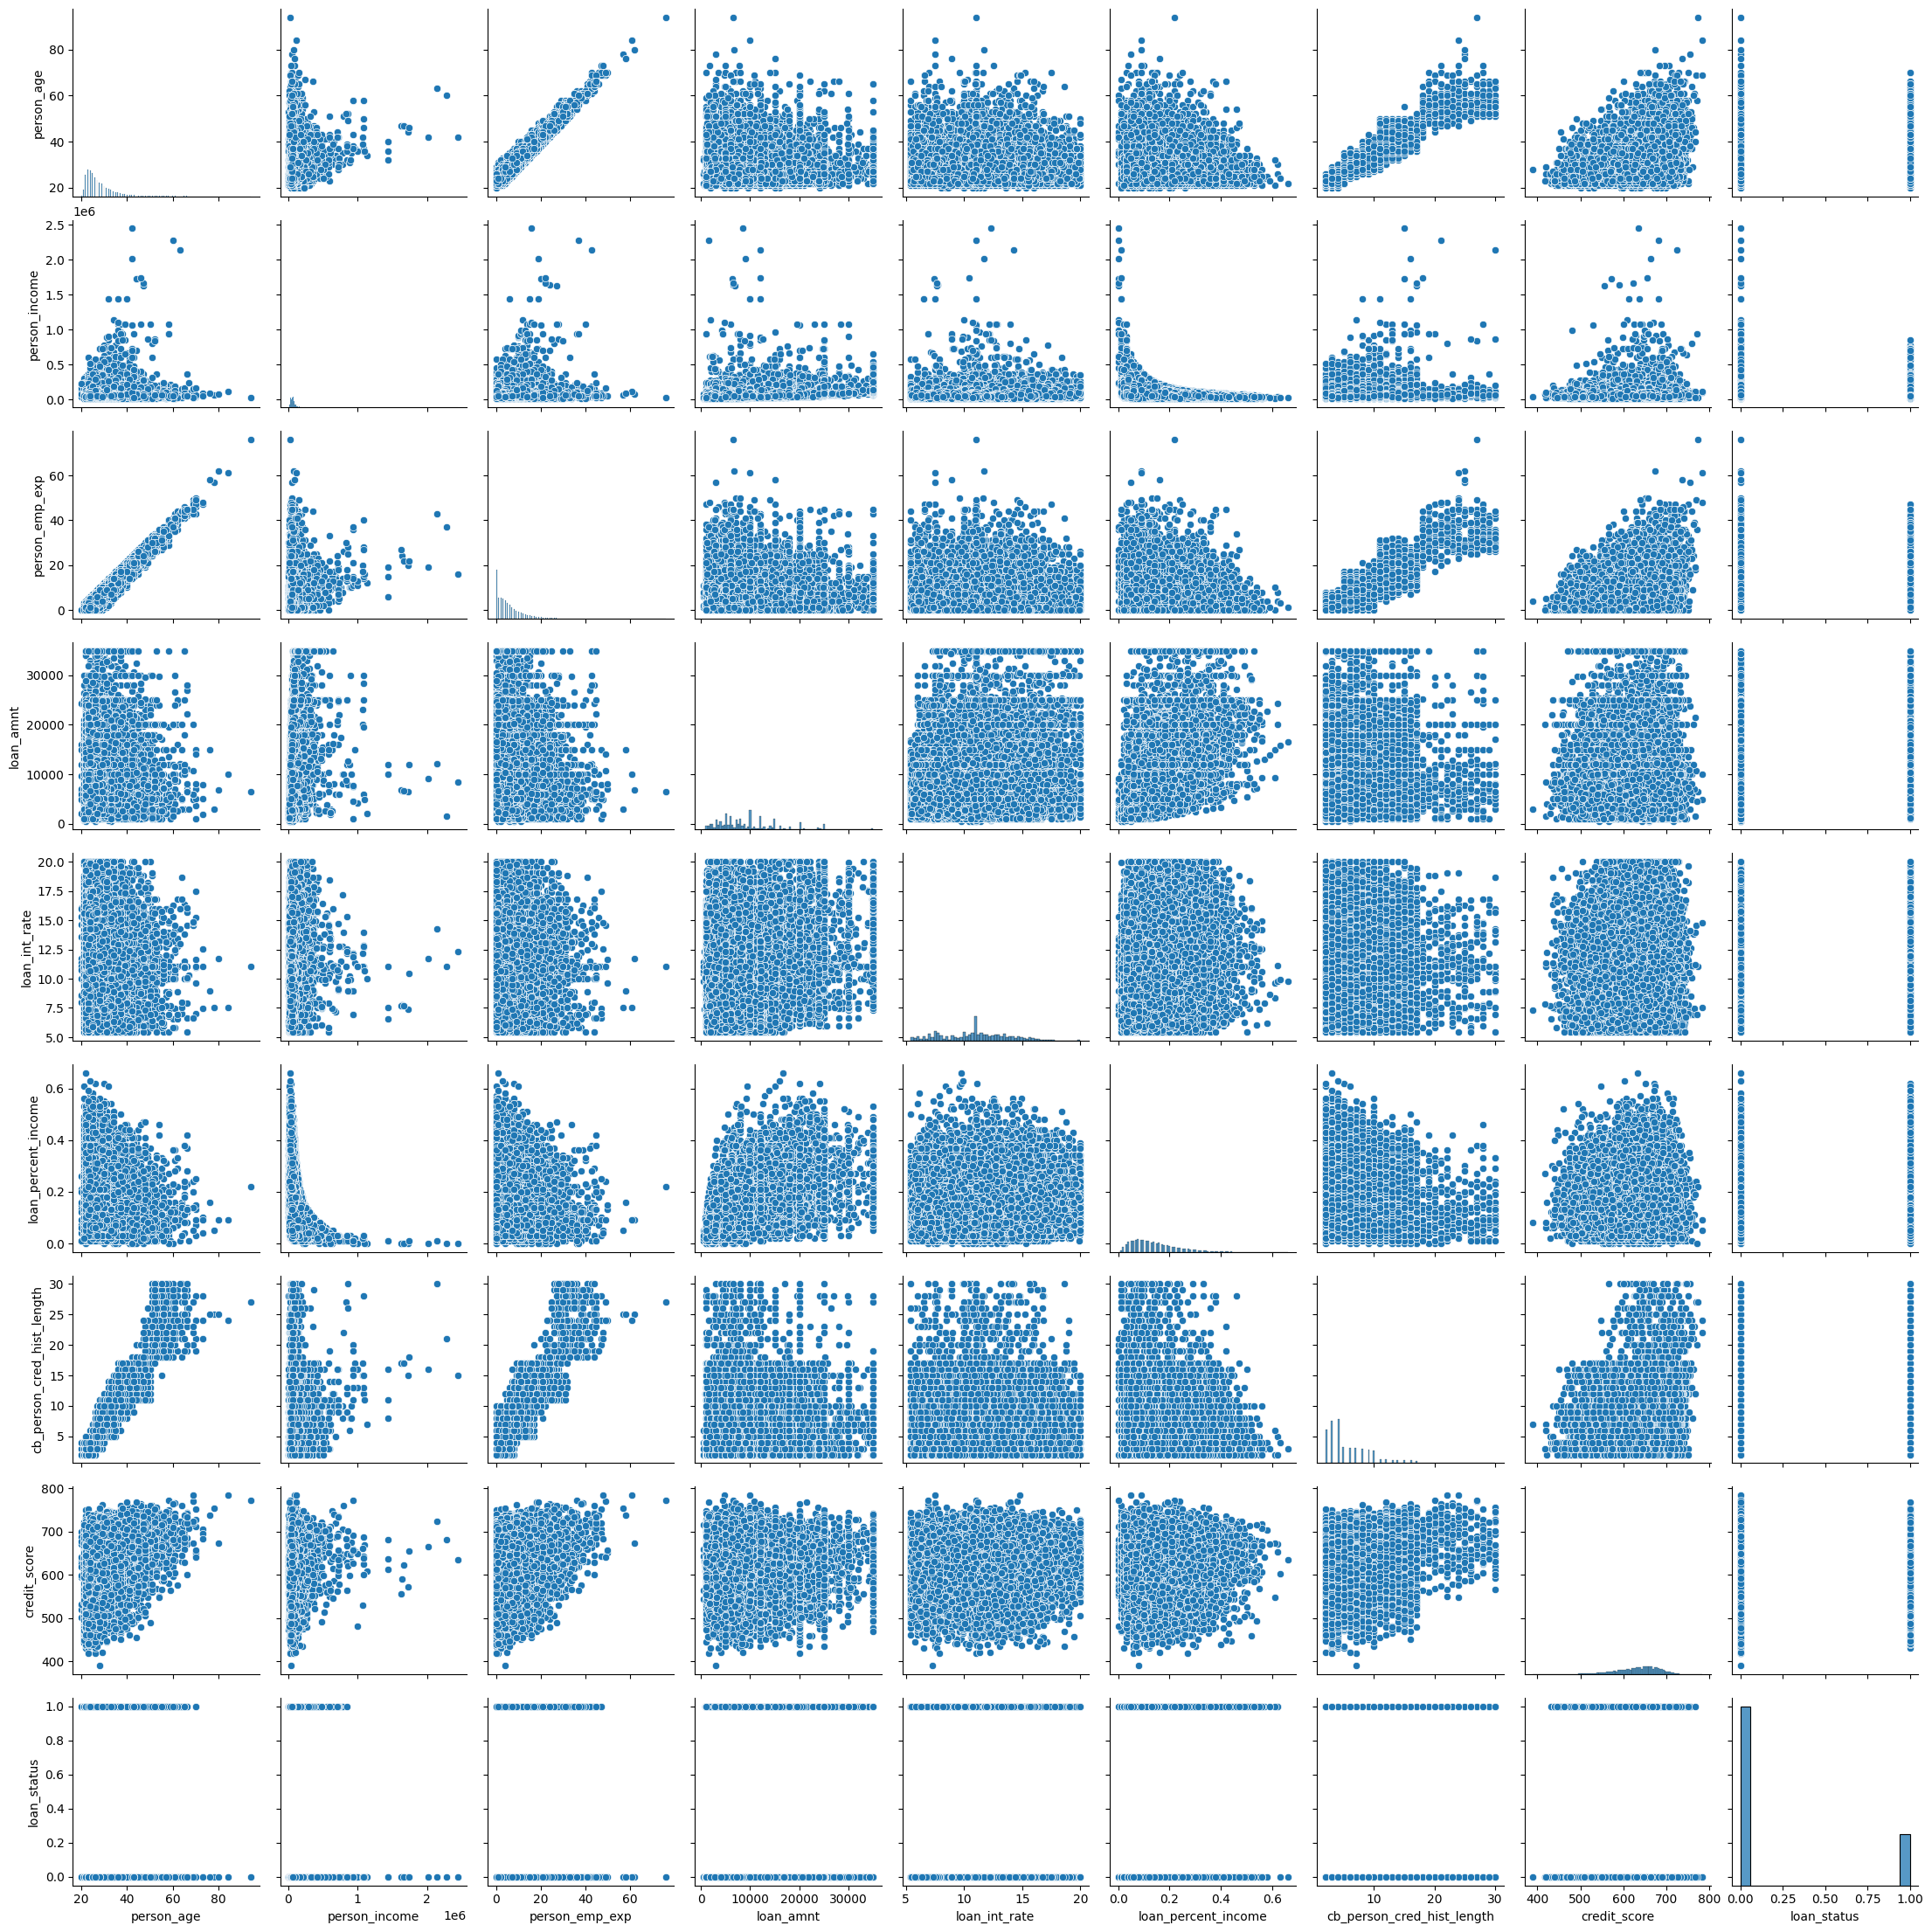

In [17]:
sns.pairplot(df.select_dtypes(include='number'))

## Business Questions

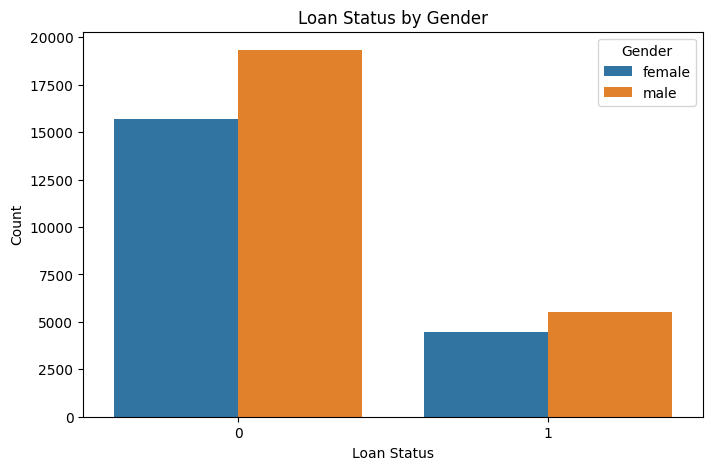

In [18]:
## Does the gender affect the loan status?
plt.figure(figsize=(8, 5))
sns.countplot(x="loan_status", hue="person_gender", data=df)
plt.title("Loan Status by Gender")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

/var/folders/1d/_j30nrd54nq9sqrt2zmjh5100000gn/T/ipykernel_1041/3644066524.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["loan_status"], y=df["credit_score"], palette=["red", "green"])


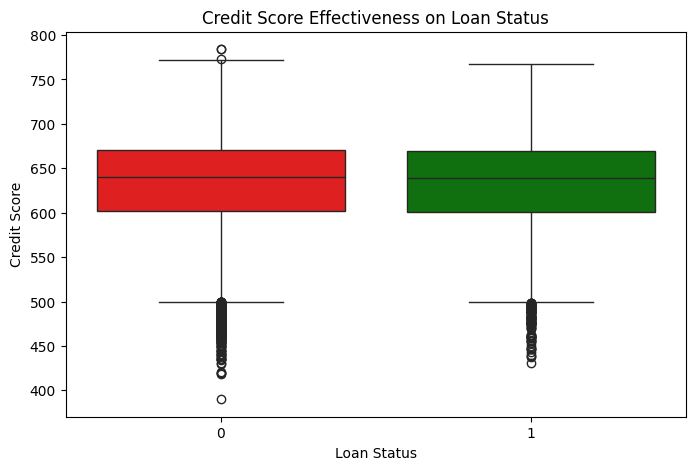

In [19]:
## Does the credit score affect the loan status?
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["loan_status"], y=df["credit_score"], palette=["red", "green"])
plt.xlabel("Loan Status")
plt.ylabel("Credit Score")
plt.title("Credit Score Effectiveness on Loan Status")
plt.show()

In [20]:
##How does income affect loan status?
df.groupby('loan_status')['person_income'].mean()

loan_status
0    85630.263567
1    59886.096900
Name: person_income, dtype: float64

In [21]:
## How do different age groups fare with loan status?
df.groupby('Age_group')['loan_status'].value_counts()

Age_group  loan_status
Middle     0               8137
           1               2136
Senior     0                238
           1                 83
Young      0              26618
           1               7781
Name: count, dtype: int64

In [22]:
# Compare loan status for different home ownership statuses?
df.groupby('person_home_ownership')['loan_status'].value_counts()

person_home_ownership  loan_status
MORTGAGE               0              16341
                       1               2144
OTHER                  0                 78
                       1                 39
OWN                    0               2729
                       1                222
RENT                   0              15845
                       1               7595
Name: count, dtype: int64

In [23]:
## Does a higher loan amount decrease the chance of repayment?
df.groupby('loan_status')['loan_amnt'].mean()

loan_status
0     9219.528877
1    10855.689800
Name: loan_amnt, dtype: float64

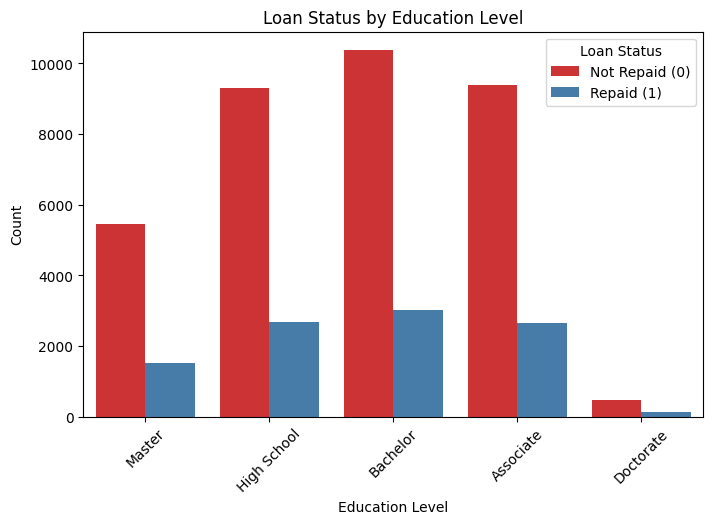

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x='person_education', hue='loan_status', data=df, palette='Set1')
plt.title("Loan Status by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Loan Status', labels=['Not Repaid (0)', 'Repaid (1)'])
plt.show()

## Train Test Split

In [25]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.777743
1    0.222257
Name: proportion, dtype: float64

In [26]:
X = df.drop(["loan_status"], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
X_train

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,credit_score_rate,Age_group,income_rate
35295,31.0,female,Associate,44485.0,4,RENT,8000.0,PERSONAL,8.83,0.18,8.0,668,Yes,Good,Middle,Low
9742,24.0,female,Master,35851.0,0,RENT,8725.0,MEDICAL,12.18,0.24,2.0,645,Yes,Average,Young,Low
26762,28.0,female,High School,121251.0,6,MORTGAGE,25000.0,VENTURE,11.01,0.21,6.0,569,No,Average,Young,Average
12940,23.0,female,High School,76537.0,1,RENT,12000.0,MEDICAL,14.96,0.16,4.0,538,No,poor,Young,Average
464,24.0,male,Associate,53633.0,4,RENT,23975.0,HOMEIMPROVEMENT,11.01,0.45,2.0,678,No,Good,Young,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,26.0,male,Associate,150915.0,2,RENT,3000.0,MEDICAL,12.21,0.02,4.0,625,Yes,Average,Young,High
44117,27.0,male,Associate,56203.0,2,RENT,15000.0,PERSONAL,14.54,0.27,6.0,525,No,poor,Young,Average
26064,27.0,female,Master,114950.0,4,MORTGAGE,15000.0,PERSONAL,7.51,0.13,9.0,569,Yes,Average,Young,Average
37090,25.0,male,Associate,126747.0,0,MORTGAGE,5000.0,PERSONAL,15.13,0.04,3.0,563,Yes,Average,Young,Average


In [27]:
y_train.value_counts(normalize=True)

loan_status
0    0.777741
1    0.222259
Name: proportion, dtype: float64

In [28]:
from sklearn.base import TransformerMixin, BaseEstimator


class LogTransformer(BaseEstimator, TransformerMixin):

    # fit
    def fit(self, X, y=None):
        # self.feature_names = list(X.columns)
        self.n_features_in = X.shape[1]
        return self

    # transformer
    def transform(self, X, y=None):
        assert self.n_features_in == X.shape[1]
        return np.log(X)

    # def get_feature_names_out(self, X, y=None):
    #     return self.feature_names



log_transformer = LogTransformer()
log_transformer

LogTransformer()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44993 entries, 0 to 44992
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44993 non-null  float64
 1   person_gender                   44993 non-null  object 
 2   person_education                44993 non-null  object 
 3   person_income                   44993 non-null  float64
 4   person_emp_exp                  44993 non-null  int64  
 5   person_home_ownership           44993 non-null  object 
 6   loan_amnt                       44993 non-null  float64
 7   loan_intent                     44993 non-null  object 
 8   loan_int_rate                   44993 non-null  float64
 9   loan_percent_income             44993 non-null  float64
 10  cb_person_cred_hist_length      44993 non-null  float64
 11  credit_score                    44993 non-null  int64  
 12  previous_loan_defaults_on_file  

In [30]:
from sklearn.preprocessing import PowerTransformer

In [31]:
## pipeline
# * c) Detect & Handle NaNs
# * d) Detect & Handle Outliers
# * e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])
# * f) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled
# * g) Imbalanced: X_train_resampled

""""
person_age -- person_emp_exp -- loan_amnt -- loan_int_rate -- loan_percent_income -- cb_person_cred_hist_length: median, log, scaling
person_gender -- person_home_ownership -- loan_intent -- person_education -- previous_loan_defaults_on_file -- credit_score_rate -- age_group -- income_rate: mode, encoding (OHE)
credit_score : mean , scaling 

loan_status: target variable
"""""
personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median'))
])


In [32]:
preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

preprocessor

ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['person_age', 'person_emp_exp', 'loan_amnt',
                                  'loan_int_rate', 'cb_person_cred_hist_length',
                                  'person_income...
                                 ['person_gender', 'person_home_ownership',
                                  'loan_intent', 'person_education',
                                  'previous_loan_defaults_on_file',
                                  'credit_score_rate', 'Age_group',
                                  'income_rate']),
                                ('credit_score',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['credit_score']),
                                ('loan_percent_income',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median'))]),
                                 ['loan_percent_income'])])

In [33]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [34]:
X_train_scaled

array([[ 0.88717699,  0.14484116, -0.01682506, ...,  1.        ,
         0.70163591,  0.18      ],
       [-0.65160365, -1.45156569,  0.11027798, ...,  1.        ,
         0.24488874,  0.24      ],
       [ 0.38351708,  0.5035285 ,  1.87815628, ...,  0.        ,
        -1.26436277,  0.21      ],
       ...,
       [ 0.1720471 ,  0.14484116,  0.96563526, ...,  0.        ,
        -1.26436277,  0.13      ],
       [-0.33997915, -1.45156569, -0.66213259, ...,  0.        ,
        -1.38351421,  0.04      ],
       [ 0.38351708,  0.5035285 ,  0.31543062, ...,  1.        ,
         0.04630301,  0.34      ]], shape=(35994, 30))

In [35]:
X_train_scaled.shape

(35994, 30)

## Fixing the imbalance

In [36]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state = 14)
# X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [37]:
# X_train_res.shape, y_train_res.shape

## Modelling

* 1) Simple Model & Validate it's perfromance



* 2) Underfitting vs Overfitting



* 3) Hyperparameters Tunning (best 5 Promissing models)



* 4) Ensemble (if needed)



* 5) Test Performance and it's CI



* 6) Save Model and load in streamlit application or flask application

In [38]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, VotingRegressor

log_reg = LogisticRegression(random_state=42, C=1.0, max_iter=1000, warm_start=False, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

print(log_reg.score(X_train_scaled, y_train))


y_train_pred = log_reg.predict(X_train_scaled)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")


y_valid_pred = cross_val_predict(log_reg, X_train_scaled, y_train, cv=3)
confusion_matrix(y_true=y_train, y_pred=y_valid_pred)
print(f"Validation Precision Score: {precision_score(y_train, y_valid_pred)}")
print(f"Validation Recall Score: {recall_score(y_train, y_valid_pred)}")
print(f"Validation f1 Score: {f1_score(y_train, y_valid_pred)}")
print(f"Validation Accuracy: {accuracy_score(y_train, y_valid_pred)}")

## this is the most simple model, so it's a underfitting

0.8630605100850142
Train Accuracy: 0.8630605100850142
Validation Precision Score: 0.6293213284634332
Validation Recall Score: 0.926125
Validation f1 Score: 0.7494057553229151
Validation Accuracy: 0.8623381674723565


### Underfitting Solutions:



* 1) More Complex Model



* 2) Extract More Features (PolynomialFeatures)



* 3) descrease constrains

In [40]:
## try Extracting polynomial features

personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])
loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
])


preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

preprocessor

ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  PowerTransformer()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['person_age', 'person_emp_exp', 'loan_amnt',
                                  'l...
                                  'income_rate']),
                                ('credit_score',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['credit_score']),
                                ('loan_percent_income',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False))]),
                                 ['loan_percent_income'])])

In [41]:
X_train_poly = preprocessor.fit_transform(X_train)
X_test_poly = preprocessor.fit_transform(X_test)

In [42]:
log_reg = LogisticRegression(random_state=42, C=1.0, max_iter=1000, warm_start=False, class_weight='balanced')
log_reg.fit(X_train_poly, y_train)
y_train_pred = log_reg.predict(X_train_poly) # train
y_valid_pred = cross_val_predict(log_reg, X_train_poly, y_train, cv=3) # valid
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Validation Accuracy: {accuracy_score(y_train, y_valid_pred)}")

## There is a slight improvement with Polynomial features in the accuracy Of both train and validation

Train Accuracy: 0.8806745568705896
Validation Accuracy: 0.8757292882147024


# lets solve imbalanced



* 1) undersampling



* 2) oversampling

## First UNDERSAMPLING

In [43]:
personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])
loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
])


poly_preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

poly_preprocessor

ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  PowerTransformer()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['person_age', 'person_emp_exp', 'loan_amnt',
                                  'l...
                                  'income_rate']),
                                ('credit_score',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer()),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['credit_score']),
                                ('loan_percent_income',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=5,
                                                                     include_bias=False))]),
                                 ['loan_percent_income'])])

In [44]:
from imblearn.pipeline import Pipeline as Imb_Pipeline

undersampling_polyfeats_pipeline = Imb_Pipeline(steps=[
    ('poly_preprocessor', poly_preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
])

undersampling_polyfeats_pipeline

Pipeline(steps=[('poly_preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person...
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42))])

In [45]:
## Pre-processor without Polynomial features

personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])
loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
])


preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

preprocessor


undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
])

undersampling_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                   'previous_loan_defaults_on_file',
                                                   'credit_score_rate',
                                                   'Age_group',
                                                   'income_rate']),
                                                 ('credit_score',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42))])

## # 2) Underfitting vs Overfitting

### We now know dataset in not linear (so let's try [Logistic Regression - KNN - GaussianNB - SVC - DT - Ensamble])

## Logestic Regression


In [46]:
from sklearn.model_selection import KFold

valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

undersampling_pipeline = Imb_Pipeline(steps=[
    ('poly_preprocessor', poly_preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced'))
    ])
undersampling_pipeline.fit(X_train, y_train)
y_train_pred = undersampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

Train Accuracy: 0.8747569039284325


In [47]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    
    undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced'))
    ])

    undersampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = undersampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8567258751051412
Average Valid F1 Score: 0.7422388462048175
Average Valid Precsion: 0.6189150201059939
Average Valid Recall: 0.927375


## KNN

In [48]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=25, leaf_size=10))
    ])
undersampling_pipeline.fit(X_train, y_train)
y_train_pred = undersampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

Train Accuracy: 0.8500305606489971


In [49]:
skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=25, leaf_size=10))
    ])

    undersampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = undersampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8431125259323897
Average Valid F1 Score: 0.7205212091617854
Average Valid Precsion: 0.5966881621246803
Average Valid Recall: 0.9094999999999999


## GaussianNB

In [50]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", GaussianNB())
    ])
undersampling_pipeline.fit(X_train, y_train)
y_train_pred = undersampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

Train Accuracy: 0.7629327110073901


In [51]:
skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train):
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", GaussianNB())
    ])

    undersampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = undersampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.7628490743500735
Average Valid F1 Score: 0.6440384889321765
Average Valid Precsion: 0.483366581504889
Average Valid Recall: 0.9650000000000001


## SVC

In [52]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42))
    ])
undersampling_pipeline.fit(X_train, y_train)
y_train_pred = undersampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

Train Accuracy: 0.8825915430349502


In [53]:
skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42))
    ])

    undersampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = undersampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.872450690393733
Average Valid F1 Score: 0.7612926738837518
Average Valid Precsion: 0.6522139547876669
Average Valid Recall: 0.9145


## DT

In [54]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
    ])
undersampling_pipeline.fit(X_train, y_train)
y_train_pred = undersampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

Train Accuracy: 0.8651719731066289


In [55]:
skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
    ])

    undersampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = undersampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8714227351125186
Average Valid F1 Score: 0.7569275465151772
Average Valid Precsion: 0.6537967678402158
Average Valid Recall: 0.9


## Gridsearch

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as Imb_Pipeline


log_params_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__max_iter': [1000, 2000],
    'model__class_weight': ['balanced', None],
}
undersampling_pipeline = Imb_Pipeline(steps=[
    ('poly_preprocessor', poly_preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(C=1.0, max_iter=1000, random_state=42))
])

logestic_grid = GridSearchCV(undersampling_pipeline, log_params_grid, cv=3, n_jobs=-1, scoring='f1')

In [57]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train):
    print(f"At fold {i}")

    logestic_grid.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    best_logestic_model = logestic_grid.best_estimator_
    y_valid_pred = logestic_grid.predict(X_train.iloc[valid_indx])

    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))

    i += 1


print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8714227737088457
Average Valid F1 Score: 0.7600491181080695
Average Valid Precsion: 0.6498885327087078
Average Valid Recall: 0.915625


In [58]:
logestic_grid.best_params_

{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 1000}

In [59]:
best_logestic_model.fit(X_train, y_train)

Pipeline(steps=[('poly_preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person...
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

In [60]:
params_grid = {'model__n_neighbors': [5, 13, 17, 25, 31],
               'model__leaf_size':[10, 20, 30, 40, 50],
               }

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=77, leaf_size=50)) 
    ])

knn_grid = GridSearchCV(undersampling_pipeline, params_grid, cv=3, n_jobs=-1, scoring='f1')

In [61]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train):
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()

    knn_grid.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    best_knn_model = knn_grid.best_estimator_
    y_valid_pred = knn_grid.predict(X_train.iloc[valid_indx])

    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))

    i += 1



print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8425291115692838
Average Valid F1 Score: 0.7196459969030155
Average Valid Precsion: 0.5957661080844614
Average Valid Recall: 0.9088750000000001


In [62]:
knn_grid.best_params_

{'model__leaf_size': 10, 'model__n_neighbors': 25}

In [63]:
best_knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                   'income_rate']),
                                                 ('credit_score',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42)),
                ('model', KNeighborsClassifier(leaf_size=10, n_neighbors=25))])

In [97]:
params_grid = [{'model__C': [0.1, 0.5, 1, 20],
               'model__kernel':['poly'],
               'model__degree':[2, 3, 4],
               'model__coef0':[5, 10],
               }
              ]

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", SVC(C=1.0, kernel='poly', degree=4, coef0=10, random_state=42, probability=True)) # 33 Model
    ])

svc_clf_grid = HalvingGridSearchCV(undersampling_pipeline, params_grid, cv=3, n_jobs=-1, random_state=42, scoring='f1')

In [98]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 150 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()

    svc_clf_grid.fit(X_train.iloc[train_indx], y_train.iloc[train_indx]) # 30 Model
    best_svc_clf_model = svc_clf_grid.best_estimator_
    y_valid_pred = svc_clf_grid.predict(X_train.iloc[valid_indx])

    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))

    i += 1



print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1


At fold 2


/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/Users/nadagam

At fold 3


/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/Users/nadagam

At fold 4
At fold 5


/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nadagamal/Documents/envs_old/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/Users/nadagam

Average Valid Accuracy: 0.8680056285795923
Average Valid F1 Score: 0.7570739439120973
Average Valid Precsion: 0.640974025140723
Average Valid Recall: 0.9248749999999999


In [99]:
svc_clf_grid.best_params_

{'model__C': 0.1,
 'model__coef0': 5,
 'model__degree': 4,
 'model__kernel': 'poly'}

In [100]:
best_svc_clf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42)),
                ('model',
                 SVC(C=0.1, coef0=5, degree=4, kernel='poly', probability=True,
                     random_state=42))])

In [68]:
params_grid = {'model__max_depth': [3, 5, 7, 10, 20],
               'model__max_leaf_nodes':[5, 10, 20],
               'model__min_samples_split':[20, 25, 30],
               'model__min_samples_leaf':[10, 20, 30],
               }

undersampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", DecisionTreeClassifier(max_depth=5, max_leaf_nodes=5, random_state=42, min_samples_split=20, min_samples_leaf=10))
    ])

dt_clf_grid = GridSearchCV(undersampling_pipeline, params_grid, cv=3, n_jobs=-1, scoring='f1')

In [69]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train):
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()

    dt_clf_grid.fit(X_train.iloc[train_indx], y_train.iloc[train_indx]) # 405 Model
    best_dt_clf_model = dt_clf_grid.best_estimator_
    y_valid_pred = dt_clf_grid.predict(X_train.iloc[valid_indx])

    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))

    i += 1



print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8653663383907515
Average Valid F1 Score: 0.7509085474286209
Average Valid Precsion: 0.6387843104622128
Average Valid Recall: 0.9119999999999999


In [70]:
dt_clf_grid.best_params_

{'model__max_depth': 10,
 'model__max_leaf_nodes': 20,
 'model__min_samples_leaf': 20,
 'model__min_samples_split': 20}

In [71]:
best_dt_clf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', RandomUnderSampler(random_state=42)),
                ('model',
                 DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20,
                                        min_samples_leaf=20,
                                        min_samples_split=20,
                                        random_state=42))])

# Oversampling

In [72]:
personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])
loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
])


poly_preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

from imblearn.pipeline import Pipeline as Imb_Pipeline

oversampling_polyfeats_pipeline = Imb_Pipeline(steps=[
    ('poly_preprocessor', poly_preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
])

oversampling_polyfeats_pipeline

Pipeline(steps=[('poly_preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person...
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', SMOTE(random_state=42))])

In [73]:
personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', PowerTransformer(method='yeo-johnson')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])

persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

credit_score = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scale', StandardScaler())
])
loan_percent_income = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    # ('poly', PolynomialFeatures(degree=5, include_bias=False)),
])


preprocessor = ColumnTransformer(transformers=[
    ('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlengt_personincome,['person_age','person_emp_exp','loan_amnt','loan_int_rate','cb_person_cred_hist_length','person_income']),
    ('persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate',persongender_personhomeownership_loanintent_personeducation_previousloandefaultsonfile_creditscorerate_agegroup_incomerate,['person_gender','person_home_ownership','loan_intent','person_education','previous_loan_defaults_on_file','credit_score_rate','Age_group','income_rate']),
    ('credit_score', credit_score, ['credit_score']),
    ('loan_percent_income', loan_percent_income, ['loan_percent_income'])
])

preprocessor


oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(k_neighbors=1, random_state=42)),
])

oversampling_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                   'previous_loan_defaults_on_file',
                                                   'credit_score_rate',
                                                   'Age_group',
                                                   'income_rate']),
                                                 ('credit_score',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['credit_score']),
                                                 ('loan_percent_income',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['loan_percent_income'])])),
                ('solve_imbalanced', SMOTE(k_neighbors=1, random_state=42))])

In [74]:
X_train_df, y_train_df = oversampling_pipeline.fit_resample(X_train, y_train)
X_train_df = pd.DataFrame(X_train_df)
y_train_df = pd.DataFrame(y_train_df)
X_train_df.duplicated().sum()

np.int64(0)

In [75]:
y_train_df.value_counts()

loan_status
0              27994
1              27994
Name: count, dtype: int64

## Logistic - Oversampling

In [76]:
from sklearn.model_selection import KFold

valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

oversampling_pipeline = Imb_Pipeline(steps=[
    ('poly_preprocessor', poly_preprocessor),
    ('solve_imbalanced', SMOTE(k_neighbors=5, random_state=42)),
    ("model", LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced'))
    ])
oversampling_pipeline.fit(X_train, y_train)
y_train_pred = oversampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(k_neighbors=5, random_state=42)),
    ("model", LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced'))
    ])

    oversampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = oversampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.8810357281769183
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8640604625360698
Average Valid F1 Score: 0.7499720251929378
Average Valid Precsion: 0.6347010335934183
Average Valid Recall: 0.9167500000000001


## KNN

In [77]:
from sklearn.model_selection import KFold

valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=25, leaf_size=10))
    ])
oversampling_pipeline.fit(X_train, y_train)
y_train_pred = oversampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=25, leaf_size=10))
    ])

    oversampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = oversampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.8493360004445185
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8308327763561678
Average Valid F1 Score: 0.7080834784422896
Average Valid Precsion: 0.5745251042507147
Average Valid Recall: 0.92275


## Guassian

In [78]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", GaussianNB())
    ])
oversampling_pipeline.fit(X_train, y_train)
y_train_pred = oversampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): 
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", GaussianNB())
    ])

    oversampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = oversampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.7652942157026171
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.7640714547700641
Average Valid F1 Score: 0.638340686807463
Average Valid Precsion: 0.48424594372263813
Average Valid Recall: 0.9365


## SVC

In [79]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42))
    ])
oversampling_pipeline.fit(X_train, y_train)
y_train_pred = oversampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42))
    ])

    oversampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = oversampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.911901983663944
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8936211193853488
Average Valid F1 Score: 0.7820023275454312
Average Valid Precsion: 0.7182543098907661
Average Valid Recall: 0.8582500000000002


## DT

In [80]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', RandomUnderSampler(random_state=42)),
    ("model", DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
    ])
oversampling_pipeline.fit(X_train, y_train)
y_train_pred = oversampling_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    # print(y_train.iloc[train_indx].value_counts(normalize=True))
    # print(y_train.iloc[valid_indx].value_counts(normalize=True))
    # print()
    
    oversampling_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
    ])

    oversampling_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = oversampling_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.8651719731066289
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8818134299085487
Average Valid F1 Score: 0.7631243548992608
Average Valid Precsion: 0.6893283550329407
Average Valid Recall: 0.8555000000000001


In [87]:
## Oversampling was better than Undersampling

from sklearn.ensemble import VotingClassifier, VotingRegressor # Ensemble (Voting)
voting_clf = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced')),
    ('svc', SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42, probability=True)),
    ('dt', DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
], voting='soft',
    n_jobs=-1
)

voting_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", voting_clf) 
    ])
voting_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42)),
                                              ('svc',
                                               SVC(C=0.1, coef0=5, degree=4,
                                                   kernel='poly',
                                                   probability=True,
                                                   random_state=42)),
                                              ('dt',
                                               DecisionTreeClassifier(max_depth=10,
                                                                      max_leaf_nodes=20,
                                                                      min_samples_leaf=20,
                                                                      min_samples_split=20,
                                                                      random_state=42))],
                                  n_jobs=-1, voting='soft'))])

In [88]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

voting_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", voting_clf) 
    ])

voting_pipeline.fit(X_train, y_train)
y_train_pred = voting_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train):
    print(f"At fold {i}")
    
    voting_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", voting_clf) 
    ])

    voting_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = voting_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.8981496916152693
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8897314780181758
Average Valid F1 Score: 0.7823333663246023
Average Valid Precsion: 0.6973277927459004
Average Valid Recall: 0.89125


In [89]:
voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42)),
                                              ('svc',
                                               SVC(C=0.1, coef0=5, degree=4,
                                                   kernel='poly',
                                                   probability=True,
                                                   random_state=42)),
                                              ('dt',
                                               DecisionTreeClassifier(max_depth=10,
                                                                      max_leaf_nodes=20,
                                                                      min_samples_leaf=20,
                                                                      min_samples_split=20,
                                                                      random_state=42))],
                                  n_jobs=-1, voting='soft'))])

In [90]:
from sklearn.ensemble import StackingClassifier, StackingRegressor # Stacking

stacking_clf = StackingClassifier(estimators=[
    ('logistic', LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced')),
    ('svc', SVC(C=0.1, kernel='poly', degree=4, coef0=5, random_state=42, probability=True)),
    ('dt', DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=20))
], final_estimator=LogisticRegression(C=0.1, max_iter=1000, random_state=42, class_weight='balanced'),
    n_jobs=-1
)
stacking_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", stacking_clf) 
    ])
stacking_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                                    class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42)),
                                                ('svc',
                                                 SVC(C=0.1, coef0=5, degree=4,
                                                     kernel='poly',
                                                     probability=True,
                                                     random_state=42)),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=10,
                                                                        max_leaf_nodes=20,
                                                                        min_samples_leaf=20,
                                                                        min_samples_split=20,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(C=0.1,
                                                                       class_weight='balanced',
                                                                       max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1))])

In [91]:
valid_accuracy_score = []
valid_f1_score = []
valid_precision_score = []
valid_recall_score = []

stacking_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", stacking_clf) # 135 Model
])

stacking_pipeline.fit(X_train, y_train)
y_train_pred = stacking_pipeline.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_indx, valid_indx in skfolds.split(X_train, y_train): # 5 Model
    print(f"At fold {i}")
    
    stacking_pipeline = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('solve_imbalanced', SMOTE(random_state=42)),
    ("model", stacking_clf) # 135 Model
    ])

    stacking_pipeline.fit(X_train.iloc[train_indx], y_train.iloc[train_indx])
    y_valid_pred = stacking_pipeline.predict(X_train.iloc[valid_indx])
    
    valid_accuracy_score.append(accuracy_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_f1_score.append(f1_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_precision_score.append(precision_score(y_train.iloc[valid_indx], y_valid_pred))
    valid_recall_score.append(recall_score(y_train.iloc[valid_indx], y_valid_pred))
    
    i += 1

print(f"Average Valid Accuracy: {np.mean(valid_accuracy_score)}") # Valid accuracy
print(f"Average Valid F1 Score: {np.mean(valid_f1_score)}") # Valid F1
print(f"Average Valid Precsion: {np.mean(valid_precision_score)}") # Valid Precsion
print(f"Average Valid Recall: {np.mean(valid_recall_score)}") # Valid Recall

Train Accuracy: 0.913291104072901
At fold 1
At fold 2
At fold 3
At fold 4
At fold 5
Average Valid Accuracy: 0.8992331527321126
Average Valid F1 Score: 0.7904623936389619
Average Valid Precsion: 0.7350729056655604
Average Valid Recall: 0.8550000000000001


In [92]:
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('personage_personempexp_loanamnt_loanintrate_cbpersoncredhistlength_personincome',
                                                  Pipeline(steps=[('handle_nans',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('handle_outliers',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_emp_exp',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_...
                                                                    class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42)),
                                                ('svc',
                                                 SVC(C=0.1, coef0=5, degree=4,
                                                     kernel='poly',
                                                     probability=True,
                                                     random_state=42)),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=10,
                                                                        max_leaf_nodes=20,
                                                                        min_samples_leaf=20,
                                                                        min_samples_split=20,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(C=0.1,
                                                                       class_weight='balanced',
                                                                       max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1))])

# PR Curve on Validation Data
* to determine threshold

Getting Voting Scores
Getting Stacking Scores


Text(0, 0.5, 'precision')

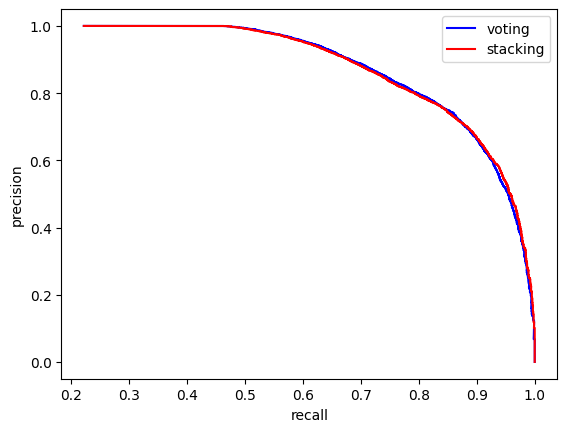

In [93]:
print("Getting Voting Scores")
y_valid_voting_prob = cross_val_predict(voting_pipeline, X_train, y_train, cv=3, method='predict_proba')
print("Getting Stacking Scores")
y_valid_stacking_prob = cross_val_predict(stacking_pipeline, X_train, y_train, cv=3, method='predict_proba')
precision_voting_scores, recall_voting_scores, voting_thresholds = precision_recall_curve(y_train, y_valid_voting_prob[:, 1])
precision_stacking_scores, recall_stacking_scores, stacking_thresholds = precision_recall_curve(y_train, y_valid_stacking_prob[:, 1])

plt.plot(precision_voting_scores[:-1], recall_voting_scores[:-1], label='voting', color='blue')
plt.plot(precision_stacking_scores[:-1], recall_stacking_scores[:-1], label='stacking', color='red')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision') 

In [94]:
y_valid_stacking_predict = cross_val_predict(stacking_pipeline, X_train, y_train, cv=3, method='predict')
confusion_matrix(y_train, y_valid_stacking_predict)

array([[25511,  2483],
       [ 1175,  6825]])

Text(0, 0.5, 'precision')

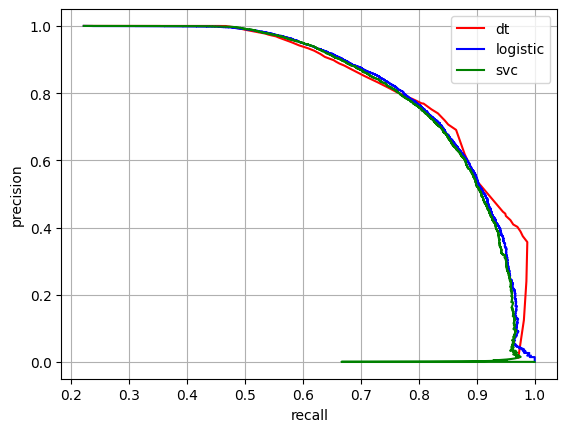

In [101]:
y_valid_dt_prob = cross_val_predict(best_dt_clf_model, X_train, y_train, cv=3, method='predict_proba')
y_valid_logistic_prob = cross_val_predict(best_logestic_model, X_train, y_train, cv=3, method='predict_proba')
y_valid_svc_prob = cross_val_predict(best_svc_clf_model, X_train, y_train, cv=3, method='predict_proba')

precision_dt_scores, recall_dt_scores, dt_thresholds = precision_recall_curve(y_train, y_valid_dt_prob[:, 1])
precision_logistic_scores, recall_logistic_scores, logistic_thresholds = precision_recall_curve(y_train, y_valid_logistic_prob[:, 1])
precision_svc_scores, recall_svc_scores, svc_thresholds = precision_recall_curve(y_train, y_valid_svc_prob[:, 1])

plt.plot(precision_dt_scores[:-1], recall_dt_scores[:-1], label='dt', color='red')
plt.plot(precision_logistic_scores[:-1], recall_logistic_scores[:-1], label='logistic', color='blue')
plt.plot(precision_svc_scores[:-1], recall_svc_scores[:-1], label='svc', color='green')
plt.legend()
plt.grid()
plt.xlabel('recall')
plt.ylabel('precision')

Text(0, 0.5, 'precision')

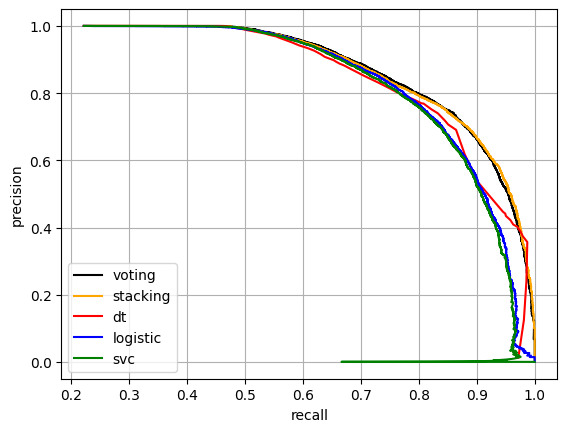

In [102]:
plt.plot(precision_voting_scores[:-1], recall_voting_scores[:-1], label='voting', color='black')
plt.plot(precision_stacking_scores[:-1], recall_stacking_scores[:-1], label='stacking', color='orange')
plt.plot(precision_dt_scores[:-1], recall_dt_scores[:-1], label='dt', color='red')
plt.plot(precision_logistic_scores[:-1], recall_logistic_scores[:-1], label='logistic', color='blue')
plt.plot(precision_svc_scores[:-1], recall_svc_scores[:-1], label='svc', color='green')
plt.legend()
plt.grid()
plt.xlabel('recall')
plt.ylabel('precision') 

Text(0, 0.5, 'tpr')

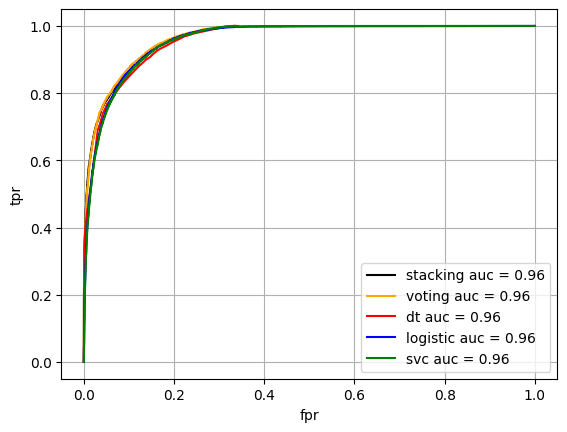

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_voting_scores, tpr_voting_scores, voting_roc_thresholds = roc_curve(y_train, y_valid_voting_prob[:, 1])
fpr_stacking_scores, tpr_stacking_scores, stacking_roc_thresholds = roc_curve(y_train, y_valid_stacking_prob[:, 1])
fpr_dt_scores, tpr_dt_scores, dt_roc_thresholds = roc_curve(y_train, y_valid_dt_prob[:, 1])
fpr_logistic_scores, tpr_logistic_scores, logistic_roc_thresholds = roc_curve(y_train, y_valid_logistic_prob[:, 1])
fpr_svc_scores, tpr_svc_scores, svc_roc_thresholds = roc_curve(y_train, y_valid_svc_prob[:, 1])

plt.plot(fpr_stacking_scores[:-1], tpr_stacking_scores[:-1], label=f'stacking auc = {roc_auc_score(y_train, y_valid_stacking_prob[:, 1]):.2f}', color='black')
plt.plot(fpr_voting_scores[:-1], tpr_voting_scores[:-1], label=f'voting auc = {roc_auc_score(y_train, y_valid_voting_prob[:, 1]):.2f}', color='orange')
plt.plot(fpr_dt_scores[:-1], tpr_dt_scores[:-1], label=f'dt auc = {roc_auc_score(y_train, y_valid_dt_prob[:, 1]):.2f}', color='red')
plt.plot(fpr_logistic_scores[:-1], tpr_logistic_scores[:-1], label=f'logistic auc = {roc_auc_score(y_train, y_valid_logistic_prob[:, 1]):.2f}', color='blue')
plt.plot(fpr_svc_scores[:-1], tpr_svc_scores[:-1], label=f'svc auc = {roc_auc_score(y_train, y_valid_svc_prob[:, 1]):.2f}', color='green')
plt.legend()
plt.grid()
plt.xlabel('fpr')
plt.ylabel('tpr')

In [105]:
indx = np.argmax(recall_stacking_scores <= 0.80)
t_80_recall = stacking_thresholds[indx]
y_stacking_prob = cross_val_predict(stacking_pipeline, X_train, y_train, cv=3, method='predict_proba')
y_stacking_threshold_pred = (y_stacking_prob[:, 1] >= t_80_recall)
print(f"Accuracy: {accuracy_score(y_train, y_stacking_threshold_pred)}") # accuracy
print(f"F1 Score: {f1_score(y_train, y_stacking_threshold_pred)}") # F1
print(f"Precsion: {precision_score(y_train, y_stacking_threshold_pred)}") # Precsion
print(f"Recall: {recall_score(y_train, y_stacking_threshold_pred)}") # Recall

Accuracy: 0.9090681780296717
F1 Score: 0.796366577490201
Precsion: 0.7927660101573145
Recall: 0.8


In [106]:
confusion_matrix(y_train, y_stacking_threshold_pred) 

array([[26321,  1673],
       [ 1600,  6400]])

# Test Performance and CI

In [107]:
y_stacking_test_pred = stacking_pipeline.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_stacking_test_pred)}") # Test accuracy
print(f"Test F1 Score: {f1_score(y_test, y_stacking_test_pred)}") # Test F1
print(f"Test Precsion: {precision_score(y_test, y_stacking_test_pred)}") # Test Precsion
print(f"Test Recall: {recall_score(y_test, y_stacking_test_pred)}") # Test Recall

Test Accuracy: 0.9034337148572064
Test F1 Score: 0.7991680147908482
Test Precsion: 0.7430167597765364
Test Recall: 0.8645


In [108]:
confusion_matrix(y_test, y_stacking_test_pred)

array([[6401,  598],
       [ 271, 1729]])

In [109]:
y_stacking_test_scores = stacking_pipeline.predict_proba(X_test)
y_stacking_test_threshold_pred = (y_stacking_test_scores[:, 1] >= t_80_recall)
print(f"Test Accuracy: {accuracy_score(y_test, y_stacking_test_threshold_pred)}") # Test accuracy
print(f"Test F1 Score: {f1_score(y_test, y_stacking_test_threshold_pred)}") # Test F1
print(f"Test Precsion: {precision_score(y_test, y_stacking_test_threshold_pred)}") # Test Precsion
print(f"Test Recall: {recall_score(y_test, y_stacking_test_threshold_pred)}") # Test Recall

Test Accuracy: 0.9119902211356817
Test F1 Score: 0.8031809145129225
Test Precsion: 0.7984189723320159
Test Recall: 0.808


In [110]:
confusion_matrix(y_test, y_stacking_test_threshold_pred)

array([[6591,  408],
       [ 384, 1616]])

# Save Model

In [111]:
joblib.dump(stacking_pipeline, 'stacking_pipeline.pkl')

['stacking_pipeline.pkl']